In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Q1

## (a)

In [45]:
df = pd.read_csv("data/hh_inc_synth.txt", header=None)
df["hhi"] = df[0]/1000
# bins
q1_bins = [0,
4999, 9999, 
14999, 19999, 
24999, 29999, 
34999, 39999, 
44999, 49999, 
54999, 59999,
64999, 69999, 
74999, 79999,
84999, 89999, 
94999, 99999, 
104999, 109999, 
114999, 119999, 
124999, 129999, 
134999, 139999, 
144999, 149999, 
154999, 159999, 
164999, 169999, 
174999, 179999, 
184999, 189999, 
194999, 199999, 
249999, 350000]
q1_bins = [num/1000 for num in q1_bins]
hist, bin_edges = np.histogram(df.hhi, q1_bins)

## (b)

In [107]:
df["weight"] = 1/len(df)/5
df.loc[(df.hhi >= 199.99) & (df.hhi < 249.99), "weight"] = df.weight/10
df.loc[(df.hhi >= 249.99), "weight"] = df.weight/20

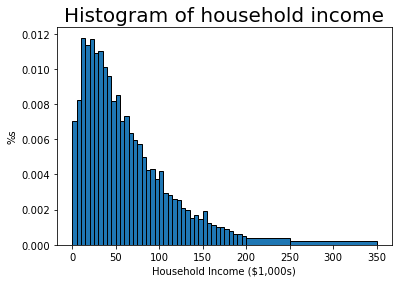

In [112]:
plt.hist(df.hhi, bins = bin_edges, weights = df.weight, edgecolor='k')
plt.title('Histogram of household income', fontsize=20)
plt.xlabel(r'Household Income ($1,000s)')
plt.ylabel(r'%s')
plt.show()

## (c):

In [368]:
def data_moments(df):
    q1_bins = [0,
    4999, 9999, 
    14999, 19999, 
    24999, 29999, 
    34999, 39999, 
    44999, 49999, 
    54999, 59999,
    64999, 69999, 
    74999, 79999,
    84999, 89999, 
    94999, 99999, 
    104999, 109999, 
    114999, 119999, 
    124999, 129999, 
    134999, 139999, 
    144999, 149999, 
    154999, 159999, 
    164999, 169999, 
    174999, 179999, 
    184999, 189999, 
    194999, 199999, 
    249999, 350000]
    q1_bins = [num/1000 for num in q1_bins]
    hist, bin_edges = np.histogram(df, q1_bins)
    '''
    for index, row in data_moments.iterrows():
        if index == len(data_moments-1):
            break
        else:
            lv = bin_edges[index]
            rv = bin_edges[index+1]
            data_moments.loc[index, "lower_bound"] = lv
            data_moments.loc[index, "upper_bound"] = rv

            data_moments.loc[index, "mid_pt"] = (rv + lv)/2
    '''
    return hist/len(df), bin_edges
        


def create_midpoints(df):
    q1_bins = [0,
    4999, 9999, 
    14999, 19999, 
    24999, 29999, 
    34999, 39999, 
    44999, 49999, 
    54999, 59999,
    64999, 69999, 
    74999, 79999,
    84999, 89999, 
    94999, 99999, 
    104999, 109999, 
    114999, 119999, 
    124999, 129999, 
    134999, 139999, 
    144999, 149999, 
    154999, 159999, 
    164999, 169999, 
    174999, 179999, 
    184999, 189999, 
    194999, 199999, 
    249999, 350000]
    q1_bins = [num/1000 for num in q1_bins]
    hist, bin_edges = np.histogram(df, q1_bins)
    mmdf = pd.DataFrame({"left_bound": bin_edges[:-1],
                    "right_bound":bin_edges[1:]})
    mmdf["mid"] = (mmdf.left_bound + mmdf.right_bound)/2
    
    return mmdf["mid"]

def lognormal_pdf(x, mu, sigma):
    pdf = 1/x/sigma/np.sqrt(2*np.pi)*np.exp(-1*(np.log(x)-mu)**2/2/sigma**2)
    return pdf

def model_moments(mu, sigma, bin_edges):
    total_n = 121085
    mmdf = pd.DataFrame({"left_bound": bin_edges[:-1],
                    "right_bound":bin_edges[1:]})
    fx = lambda x: lognormal_pdf(x, mu, sigma)
    for index, row in mmdf.iterrows():
        (model_cdf, trash) = intgr.quad(fx, row["left_bound"], row["right_bound"], limit = 200)
        mmdf.loc[index, "cdf"] =  model_cdf
    return mmdf.cdf

def err_vec(xvals, mu, sigma, simple):
    data_vec, bin_edges = data_moments(xvals)
    model_vec = model_moments(mu, sigma, bin_edges)
    if simple:
        err_vec = model_vec - data_vec
    else:
        err_vec = (model_vec - data_vec) / data_vec
    
    return err_vec

def criterion(params, args):
    mu, sigma = params
    xvals = args[0]
    simp = args[1]
    hist, trash = data_moments(xvals)
    W = np.diag(hist)
    err = err_vec(xvals, mu, sigma, simple=simp)
    crit_val = err.T @ W @ err
    return crit_val

In [369]:
mu_init = np.log(np.mean(df.hhi))
sigma_init = 1
params_init = np.array([mu_init, sigma_init])
gmm_args = [df.hhi, False]
results_v1 = opt.minimize(criterion, 
    params_init, 
    args=(gmm_args), 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-10, None), (None, None)))
mu_GMM1_v1, sig_GMM1_v1 = results_v1.x
print("mu_init is {} and sigma_init is {}".format(mu_init, sigma_init))
print('mu_GMM1=', mu_GMM1_v1, ' sig_GMM1=', sig_GMM1_v1)
print("\nValue of Minimized Criterion: {}".format(criterion((mu_GMM1_v1, sig_GMM1_v1), gmm_args)))
results_v1

mu_init is 4.208708399504983 and sigma_init is 1
mu_GMM1= 3.893431049548731  sig_GMM1= 0.9757517892222265

Value of Minimized Criterion: 0.03552341059092044


      fun: 0.03552341059092044
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.16333634e-09, 9.02056208e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([3.89343105, 0.97575179])

In [373]:
mu_init = 10
sigma_init = 1
params_init = np.array([mu_init, sigma_init])
gmm_args =  [df.hhi, False]
results_v2 = opt.minimize(criterion, 
    params_init, 
    args=(gmm_args), 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-10, None), (None, None)))
mu_GMM1_v2, sig_GMM1_v2 = results_v2.x
print("mu_init is {} and sigma_init is {}".format(mu_init, sigma_init))
print('mu_GMM1=', mu_GMM1_v2, ' sig_GMM1=', sig_GMM1_v2)
print("\nValue of Minimized Criterion: {}".format(criterion((mu_GMM1_v1, sig_GMM1_v1), gmm_args)))
results_v2

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


mu_init is 10 and sigma_init is 1
mu_GMM1= 3.8934311554181953  sig_GMM1= 0.9757517945517591

Value of Minimized Criterion: 0.03552341059092044


      fun: 0.03552341059093035
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.99840144e-07, 3.74700271e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 15
   status: 0
  success: True
        x: array([3.89343116, 0.97575179])

In [374]:
mu_init = 1
sigma_init = 1
params_init = np.array([mu_init, sigma_init])
gmm_args =  [df.hhi, False]
results_v3 = opt.minimize(criterion, 
    params_init, 
    args=(gmm_args), 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-10, None), (None, None)))
mu_GMM1_v3, sig_GMM1_v3 = results_v3.x
print("mu_init is {} and sigma_init is {}".format(mu_init, sigma_init))
print('mu_GMM1=', mu_GMM1_v3, ' sig_GMM1=', sig_GMM1_v3)
print("\nValue of Minimized Criterion: {}".format(criterion((mu_GMM1_v1, sig_GMM1_v1), gmm_args)))
results_v3

mu_init is 1 and sigma_init is 1
mu_GMM1= 3.8934310486191603  sig_GMM1= 0.9757517839165524

Value of Minimized Criterion: 0.03552341059092044


      fun: 0.035523410590920484
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.9388939e-10, -6.9388939e-10])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 11
   status: 0
  success: True
        x: array([3.89343105, 0.97575178])

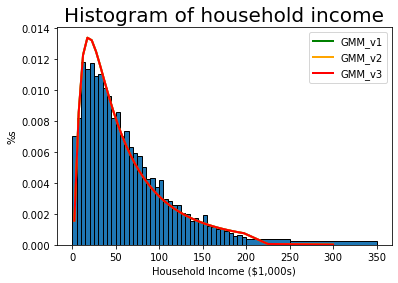

In [375]:
mid_points = create_midpoints(df.hhi)

temp_df = pd.DataFrame({"mpt": mid_points})
temp_df["v1"] = lognormal_pdf(mid_points, mu_GMM1_v1, sig_GMM1_v1)
temp_df["v2"] = lognormal_pdf(mid_points, mu_GMM1_v2, sig_GMM1_v2)
temp_df["v3"] = lognormal_pdf(mid_points, mu_GMM1_v3, sig_GMM1_v3)
temp_df.loc[40, "v1"] = temp_df.loc[40, "v1"]/10
temp_df.loc[41, "v1"] = temp_df.loc[41, "v1"]/20
temp_df.loc[40, "v2"] = temp_df.loc[40, "v2"]/10
temp_df.loc[41, "v2"] = temp_df.loc[41, "v2"]/20
temp_df.loc[40, "v3"] = temp_df.loc[40, "v3"]/10
temp_df.loc[41, "v3"] = temp_df.loc[41, "v3"]/20

plt.hist(df.hhi, bins = bin_edges, weights = df.weight, edgecolor='k')
plt.title('Histogram of household income', fontsize=20)
plt.xlabel(r'Household Income ($1,000s)')
plt.ylabel(r'%s')
plt.plot(mid_points, temp_df["v1"],
         linewidth=2, color='green', label='GMM_v1')
plt.plot(mid_points,  temp_df["v2"],
         linewidth=2, color='orange', label='GMM_v2')
plt.plot(mid_points,  temp_df["v3"],
         linewidth=2, color='red', label='GMM_v3')
plt.legend(loc='upper right')
plt.show()

## (d):

In [464]:
def GA_pdf(x, alpha, beta):
    # my hw2: 
    # pdf =  1/(beta**(alpha) * math.gamma(alpha))*x**(alpha-1)*np.exp(-x/beta)
    # wiki:
    pdf =  beta**alpha*x**(alpha-1)*np.exp(-beta*x)/math.gamma(alpha)
    return pdf

def GAmodel_moments(alpha, beta, bin_edges):
    mmdf = pd.DataFrame({"left_bound": bin_edges[:-1],
                    "right_bound":bin_edges[1:]})
    fx = lambda x: GA_pdf(x, alpha, beta)
    for index, row in mmdf.iterrows():
        (model_cdf, trash) = intgr.quad(fx, row["left_bound"], row["right_bound"], limit = 200)
        mmdf.loc[index, "cdf"] =  model_cdf
    return mmdf.cdf


def GAerr_vec(xvals, alpha, beta, simple):
    data_vec, bin_edges = data_moments(xvals)
    model_vec = GAmodel_moments(alpha, beta, bin_edges).to_numpy()
    if simple:
        err_vec = model_vec - data_vec
    else:
        err_vec = (model_vec - data_vec) / data_vec
    
    return err_vec

def GAcriterion(params, args):
    alpha, beta = params
    xvals = args[0]
    simp = args[1]
    hist, trash = data_moments(xvals)
    W = args[2]
    err = GAerr_vec(xvals, alpha, beta, simple=simp)
    crit_val = err.T @ W @ err
    return crit_val

In [465]:
hist, bin_edges = data_moments(df.hhi)
alpha_init = 3
beta_init = 1/20000
params_init = np.array([alpha_init, beta_init])
gmm_args = [df.hhi, False, np.diag(hist)]
ga_results_v1 = opt.minimize(GAcriterion, 
    params_init, 
    args=gmm_args, 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-7, None), (1e-7, None)))
GA_alpha_GMM1_v1, GA_beta_GMM1_v1 = ga_results_v1.x
print("\nalpha_init is {} and beta_init is {}".format(alpha_init, beta_init))
print("\nValue of Minimized Criterion (Initial) : {}".format(criterion((alpha_init, beta_init), gmm_args)))
print('\nalpha_GMM1=', GA_alpha_GMM1_v1, 'beta_GMM1=', GA_beta_GMM1_v1)
print("\nValue of Minimized Criterion (Final): {}".format(criterion((GA_alpha_GMM1_v1, GA_beta_GMM1_v1), gmm_args)))
ga_results_v1


alpha_init is 3 and beta_init is 5e-05

Value of Minimized Criterion (Initial) : 1.0

alpha_GMM1= 1.3670004893121428 beta_GMM1= 0.020805566006977683

Value of Minimized Criterion (Final): 27.417038253931022


      fun: 0.014084676380113365
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.32973363e-07,  1.07466119e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 16
   status: 0
  success: True
        x: array([1.36700049, 0.02080557])

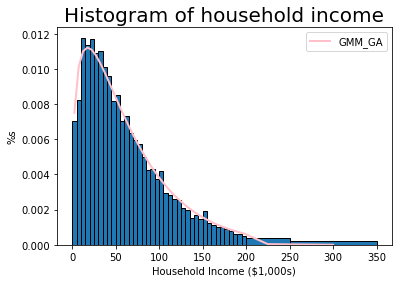

In [466]:
mid_points = create_midpoints(df.hhi)

temp_df = pd.DataFrame({"mpt": mid_points})
temp_df["v1"] = GA_pdf(mid_points, GA_alpha_GMM1_v1, GA_beta_GMM1_v1)
temp_df.loc[40, "v1"] = temp_df.loc[40, "v1"]/10
temp_df.loc[41, "v1"] = temp_df.loc[41, "v1"]/20

plt.hist(df.hhi, bins = bin_edges, weights = df.weight, edgecolor='k')
plt.title('Histogram of household income', fontsize=20)
plt.xlabel(r'Household Income ($1,000s)')
plt.ylabel(r'%s')
plt.plot(mid_points, temp_df["v1"],
         linewidth=2, color='pink', label='GMM_GA')
plt.legend(loc='upper right')
plt.show()

## (e):

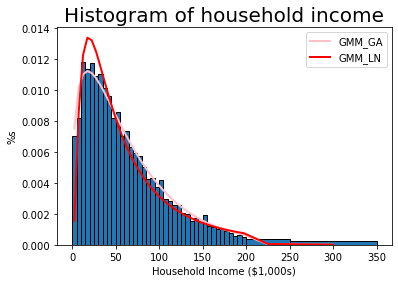

In [467]:
mid_points = create_midpoints(df.hhi)

temp_df = pd.DataFrame({"mpt": mid_points})
temp_df["GA"] = GA_pdf(mid_points, GA_alpha_GMM1_v1, GA_beta_GMM1_v1)
temp_df.loc[40, "GA"] = temp_df.loc[40, "GA"]/10
temp_df.loc[41, "GA"] = temp_df.loc[41, "GA"]/20

temp_df["LN"] = lognormal_pdf(mid_points, mu_GMM1_v1, sig_GMM1_v1)
temp_df.loc[40, "LN"] = temp_df.loc[40, "LN"]/10
temp_df.loc[41, "LN"] = temp_df.loc[41, "LN"]/20

plt.hist(df.hhi, bins = bin_edges, weights = df.weight, edgecolor='k')
plt.title('Histogram of household income', fontsize=20)
plt.xlabel(r'Household Income ($1,000s)')
plt.ylabel(r'%s')
plt.plot(mid_points, temp_df["GA"],
         linewidth=2, color='pink', label='GMM_GA')
plt.plot(mid_points, temp_df["LN"],
         linewidth=2, color='red', label='GMM_LN')
plt.legend(loc='upper right')
plt.show()

The GA distribution seems to do a slighty better job. Maybe one thing we can do is to compare the sum of squared differences between the data and model moments:

In [468]:
temp_df["actual"] = np.histogram(df.hhi, q1_bins)[0]/len(df)
print("\nSum of Squared differences between data & LN: {}".format(np.sum((temp_df.actual-temp_df.LN)**2)))
print("\nSum of Squared differences between data & GA: {}".format(np.sum((temp_df.actual-temp_df.GA)**2)))


Sum of Squared differences between data & LN: 0.024292146818871294

Sum of Squared differences between data & GA: 0.024254049379389082


GA is slightly better! 

## (f)

In [469]:
def get_errmatrix(xvals, alpha, beta, simple= False):
    data_vec, bin_edges = data_moments(xvals)
    R = 42
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    model_vec = GAmodel_moments(alpha, beta, bin_edges)
    mmdf = pd.DataFrame({"left_bound": bin_edges[:-1],
                    "right_bound":bin_edges[1:]})
    if simple:
        for index, row in mmdf.iterrows():
            lb = row["left_bound"]
            rb = row["right_bound"]
            pts_in_grp = (lb <= xvals) & (xvals < rb)
            Err_mat[index, :] = pts_in_grp- model_vec[index]
    else:
        for index, row in mmdf.iterrows():
            lb = row["left_bound"]
            rb = row["right_bound"]
            pts_in_grp = (lb <= xvals) & (xvals < rb)
            Err_mat[index, :] = (pts_in_grp- model_vec[index])/model_vec[index]
    return Err_mat

In [470]:
emt = get_errmatrix(df.hhi, GA_alpha_GMM1_v1, GA_beta_GMM1_v1)

In [472]:
omega1 = 1/len(df) * emt @ emt.T
new_w = lin.pinv(omega1)

In [473]:
hist, bin_edges = data_moments(df.hhi)
alpha_init = GA_alpha_GMM1_v1
beta_init = GA_beta_GMM1_v1
params_init = np.array([alpha_init, beta_init])
gmm_args = [df.hhi, False, new_w]
ga_results_v2 = opt.minimize(GAcriterion, 
    params_init, 
    args=gmm_args, 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-7, None), (1e-7, None)))
GA_alpha_GMM1_v2, GA_beta_GMM1_v2 = ga_results_v2.x
print("\nalpha_init is {} and beta_init is {}".format(alpha_init, beta_init))
print("\nValue of Minimized Criterion (Initial) : {}".format(criterion((alpha_init, beta_init), gmm_args)))
print('\nalpha_GMM1=', GA_alpha_GMM1_v2, 'beta_GMM1=', GA_beta_GMM1_v2)
print("\nValue of Minimized Criterion (Final): {}".format(criterion((GA_alpha_GMM1_v2, GA_beta_GMM1_v2), gmm_args)))
ga_results_v2



alpha_init is 1.3670004893121428 and beta_init is 0.020805566006977683

Value of Minimized Criterion (Initial) : 27.417038253931022

alpha_GMM1= 1.096698347779921 beta_GMM1= 0.013781609642212877

Value of Minimized Criterion (Final): 27.417038253931032


      fun: 0.07536693526880264
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.32323663e-05, -1.19895066e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 17
   status: 0
  success: True
        x: array([1.09669835, 0.01378161])

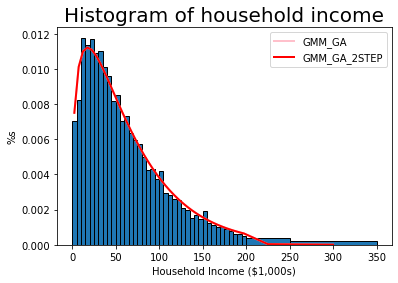

In [474]:
mid_points = create_midpoints(df.hhi)

temp_df = pd.DataFrame({"mpt": mid_points})
temp_df["v1"] = GA_pdf(mid_points, GA_alpha_GMM1_v1, GA_beta_GMM1_v1)
temp_df.loc[40, "v1"] = temp_df.loc[40, "v1"]/10
temp_df.loc[41, "v1"] = temp_df.loc[41, "v1"]/20
temp_df["v2"] = GA_pdf(mid_points, GA_alpha_GMM1_v2, GA_beta_GMM1_v2)
temp_df.loc[40, "v2"] = temp_df.loc[40, "v2"]/10
temp_df.loc[41, "v2"] = temp_df.loc[41, "v2"]/20

plt.hist(df.hhi, bins = bin_edges, weights = df.weight, edgecolor='k')
plt.title('Histogram of household income', fontsize=20)
plt.xlabel(r'Household Income ($1,000s)')
plt.ylabel(r'%s')
plt.plot(mid_points, temp_df["v1"],
         linewidth=2, color='pink', label='GMM_GA')
plt.plot(mid_points, temp_df["v1"],
         linewidth=2, color='red', label='GMM_GA_2STEP')
plt.legend(loc='upper right')
plt.show()

They do change a bit. Comparing the Sum of Squared Errors per bini as before, I find the following:

In [476]:
temp_df["actual"] = np.histogram(df.hhi, q1_bins)[0]/len(df)
print("\nSum of Squared differences between data & GA: {}".format(np.sum((temp_df.actual-temp_df.v1)**2)))
print("\nSum of Squared differences between data & GA_2step: {}".format(np.sum((temp_df.actual-temp_df.v2)**2)))


Sum of Squared differences between data & GA: 0.024254049379389082

Sum of Squared differences between data & GA_2step: 0.025408666449959285


# 2:

In [10]:
import random

In [2]:
df = pd.read_csv("data/MacroSeries.txt", header=None)
df["c"] = df[0]
df["k"] = df[1]
df["w"] = df[2]
df["r"] = df[3]
df = df.loc[:,["c", "k", "w", "r"]]

In [86]:
def p2_data_moments(df, alpha, rho, mu):
    # construct Zs
    random.seed(47)
    beta = 0.99
    for index, row in df.iterrows():
        intial_r = df.r[index]
        initial_k = df.k[index]
        initial_z = np.log(intial_r/alpha/initial_k**(alpha-1))
        df.loc[index, "z"] = initial_z
    
    m1 = 0
    m2 = 0
    m3 = 0
    m4 = 0 
    counter = 1

    for index, row in df.iterrows():
        if index < len(df)-1:
            # m1
            row2 = df.loc[index+1,:]
            m1 += row2.z - rho*row.z - (1-rho)*mu

            # m2
            m2 += (row2.z- rho*row.z - (1-rho)*mu)*row.z
            
            # m3
            m3 +=  beta*alpha*np.exp(row2.z)*row2.k**(alpha-1)*row.c/row2.c-1

            # m4
            m4 += (beta*alpha*np.exp(row2.z)*row2.k**(alpha-1)*row.c/row2.c-1)*row.w
            counter += 1
            
    return np.array([m1/counter, m2/counter ,m3/counter ,m4/counter])

def p2_err_vec(xvals, alpha, rho, mu):
    model_vec = np.array([0, 0, 0 ,0])
    data_vec = p2_data_moments(xvals, alpha, rho, mu)
    err_vec = model_vec - data_vec
    return err_vec

def p2_criterion(params, args):
    alpha, rho, mu = params
    xvals  = args[0]
    W = args[1]
    err = p2_err_vec(xvals, alpha, rho, mu)
    crit_val = err.T @ W @ err
    return crit_val

In [100]:
alpha_init = 0.6
rho_init = 0.6
mu_init = 2
params_init = np.array([alpha_init, rho_init, mu_init])
gmm_args = [df, np.eye(4)]
results_v1 = opt.minimize(p2_criterion, 
    params_init, 
    args=gmm_args, 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-10, 1-1e-10), (-1+1e-10, 1-1e-10), (1e-10, None)))

In [101]:
alpha_GMM, rho_GMM, mu_GMM = results_v1.x
print("\n alpha_init = {}, rho_init = {}, and mu_init = {}".format(alpha_init, rho_init, mu_init))
print("\n alpha_GMM = {}, rho_GMM = {}, and mu_GMM = {}".format(alpha_GMM, rho_GMM, mu_GMM))
print("\nValue of Minimized Criterion: {}".format(p2_criterion((alpha_GMM, rho_GMM, mu_GMM), gmm_args)))
results_v1


 alpha_init = 0.6, rho_init = 0.6, and mu_init = 2

 alpha_GMM = 0.6065708326600074, rho_GMM = 0.6026525357413061, and mu_GMM = 6.731832794974998

Value of Minimized Criterion: 8.235559930587744e-10


      fun: 8.235559930587744e-10
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.10125633e-05, 1.07818544e-07, 1.82777993e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 68
      nit: 7
   status: 0
  success: True
        x: array([0.60657083, 0.60265254, 6.73183279])

## (b):

In [102]:
def p2_errmatrix(df, alpha, rho, mu):
    edf = pd.DataFrame()
    beta = 0.99
    for index, row in df.iterrows():
        intial_r = df.r[index]
        initial_k = df.k[index]
        initial_z = np.log(intial_r/alpha/initial_k**(alpha-1))
        df.loc[index, "z"] = initial_z

    for i in range(0, len(df)-1):
        row = df.loc[i,:]
        row2 = df.loc[i+1,:]
        edf.loc["m1", i] = row2.z - rho*row.z - (1-rho)*mu
        edf.loc["m2", i] = (row2.z- rho*row.z - (1-rho)*mu)*row.z
        edf.loc["m3", i] = beta*alpha*np.exp(row2.z)*row2.k**(alpha-1)*row.c/row2.c-1
        edf.loc["m4", i] = (beta*alpha*np.exp(row2.z)*row2.k**(alpha-1)*row.c/row2.c-1)*row.w
    return np.array(edf)

In [103]:
emt = p2_errmatrix(df, alpha_GMM, rho_GMM, mu_GMM)
omega1 = 1/(len(df)-2) * emt @ emt.T
new_w = lin.pinv(omega1)
params_init = np.array([alpha_GMM, rho_GMM, mu_GMM])
gmm_args = [df, new_w]
ga2step_results = opt.minimize(p2_criterion, 
    params_init, 
    args=gmm_args, 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-10, 1-1e-10), (-1+1e-10, 1-1e-10), (1e-10, None)))
GA2step_alpha_GMM, GA2step_rho_GMM, GA2step_mu_GMM = ga2step_results.x

In [104]:
print("\n alpha_init = {}, rho_init = {}, and mu_init = {}".format(alpha_init, rho_init, mu_init))
print("\n alpha_GMM = {}, rho_GMM = {}, and mu_GMM = {}".format(GA2step_alpha_GMM, GA2step_rho_GMM, GA2step_mu_GMM))
print("\nValue of Minimized Criterion: {}".format(p2_criterion((GA2step_alpha_GMM, GA2step_rho_GMM, GA2step_mu_GMM), gmm_args)))
ga2step_results


 alpha_init = 0.6, rho_init = 0.6, and mu_init = 2

 alpha_GMM = 0.6065110220840169, rho_GMM = 0.5874133450508694, and mu_GMM = 6.732827263086827

Value of Minimized Criterion: 5.429561139233435e-13


      fun: 5.429561139233435e-13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.29719306e-05,  6.67114077e-07, -6.39509065e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 13
   status: 0
  success: True
        x: array([0.60651102, 0.58741335, 6.73282726])

In [105]:
def p2_jacob(df, alpha, rho, mu):
    beta = 0.99
    h_alpha = 1e-8 * alpha
    h_rho = 1e-8 * rho
    h_mu = 1e-8 * mu
    evec_alpha = p2_err_vec(df, alpha + h_alpha, rho, mu) - p2_err_vec(df, alpha - h_alpha, rho, mu)
    evec_rho = p2_err_vec(df, alpha , rho + h_rho, mu) - p2_err_vec(df, alpha , rho - h_rho, mu)
    evec_mu = p2_err_vec(df, alpha, rho, mu + h_mu) - p2_err_vec(df, alpha, rho, mu - h_mu)
    jdf = pd.DataFrame({"1": evec_alpha,
                    "2": evec_rho,
                    "3":evec_mu})
    return np.array(jdf)

In [108]:
n = len(df)-1
d_err = p2_jacob(df, GA2step_alpha_GMM, GA2step_rho_GMM, GA2step_mu_GMM)
SigHat2 = (1 / n) * (d_err.T @ new_w @ d_err)

In [109]:
print('Std. err. alpha_hat=', np.sqrt(SigHat2[0, 0]))
print('Std. err. rho_hat=', np.sqrt(SigHat2[1, 1]))
print('Std. err. mu_hat=', np.sqrt(SigHat2[2, 2]))

Std. err. alpha_hat= 9.566071801912388e-08
Std. err. rho_hat= 1.4102148324570848e-09
Std. err. mu_hat= 6.105196264778493e-08
